# Assignment 2: Data Preprocessing
## By: Cristian C Noriega M, Toyosi, Arshdeep Singh, Ang Dorje Sherpa


### Task:
Using Data Preprocessing technqiues on a chosen dataset to prepare it for future modeling/analysis

In [332]:
#cell for importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.cluster import hierarchy
import geopandas as gpd
import plotly.express as px
import folium
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from scipy.spatial.distance import euclidean

pd.set_option('display.max_rows', 35)

In [333]:
#Bringing in the two datasets we will be using and assigning them both to their own dataframe

df = pd.read_csv('world-data-2023.csv')
continent_df = pd.read_csv('Continent List.csv')

In [334]:
# Brief overview of the main dataset that shows name and datatype of columns and number of rows. 
# There are null values in pretty much every column. We will have to spend time fixing them as null values can cause issues later on.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                           195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                        

In [335]:
# Shows the first five columns of the dataset, shows us what to expect for each column in terms of length, type, and scale of digits.
# We can see that there are numeric and alphabetical values. 

df.head()

,Country,Density\r\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


# DATA CLEANING
#### Rename columns, drop 2 columns, and 1 country. Drop countries where there are less than 25 Non-NA values 

In [336]:
#Renaming columns for two purposes. First, is to clean the names. Secondly, the $ shows that the values are standardized to USD and 
#the values in the rate columns are percentanges ('%')

df = df.rename(columns={'Density\r\n(P/Km2)':'Density(P/km2)','Total tax rate':'Total tax rate (%)',
                        'Minimum wage':'Minimum wage($)','Unemployment rate':'Unemployment rate(%)',
                        'Gasoline Price':'Gasoline Price($)','Out of pocket health expenditure':'Out of pocket health expenditure(%)'})

In [337]:
#Dropping columns that we will not need in our analysis 'Noisy data'.
#Also dropping the country (row) with its Latitude missing as we will be plotting a map later on.

df.drop(['Abbreviation','Calling Code'],axis=1,inplace=True) #columns not needed
df.drop(df[df['Latitude'].isna()].index,inplace=True)#drop country without Latitude - name was not able to be reconigzed


In [338]:
#Dropping any country/row that has less than 25 Non-NA values as this is way too little information to be useful in analysis 

df.dropna(axis=0,inplace=True,thresh=25)

In [339]:
# Re moving duplicates as they lead to Noisy Data, and will add skew to the data if there is more than one row per country.

duplicate = df[df.duplicated('Country')]
duplicate
df_population_data=df[['Country','Population','Maternal mortality ratio','Birth Rate','Infant mortality','Physicians per thousand','Fertility Rate','GDP','Armed Forces size','Co2-Emissions','Life expectancy']]
df_population_data

,Country,Population,Maternal mortality ratio,Birth Rate,Infant mortality,Physicians per thousand,Fertility Rate,GDP,Armed Forces size,Co2-Emissions,Life expectancy
0,Afghanistan,"38,041,754",638.0,32.49,47.9,0.28,4.47,"$19,101,353,833","323,000","8,672",64.5
1,Albania,"2,854,191",15.0,11.78,7.8,1.20,1.62,"$15,278,077,447","9,000","4,536",78.5
2,Algeria,"43,053,054",112.0,24.28,20.1,1.72,3.02,"$169,988,236,398","317,000","150,006",76.7
4,Angola,"31,825,295",241.0,40.73,51.6,0.21,5.52,"$94,635,415,870","117,000","34,693",60.8
5,Antigua and Barbuda,"97,118",42.0,15.33,5.0,2.76,1.99,"$1,727,759,259",0,557,76.9
...,...,...,...,...,...,...,...,...,...,...,...
190,Venezuela,"28,515,829",125.0,17.88,21.4,1.92,2.27,"$482,359,318,768","343,000","164,175",72.1
191,Vietnam,"96,462,106",43.0,16.75,16.5,0.82,2.05,"$261,921,244,843","522,000","192,668",75.3
192,Yemen,"29,161,922",164.0,30.45,42.9,0.31,3.79,"$26,914,402,224","40,000","10,609",66.1
193,Zambia,"17,861,030",213.0,36.19,40.4,1.19,4.63,"$23,064,722,446","16,000","5,141",63.5


#### Fill missing data

In [340]:
# Filling in the official language for the 4 countries, data was missing so we are doing it manually here. 

df.loc[df['Country'] == 'Australia', 'Official language'] ='English'
df.loc[df['Country'] == 'United States', 'Official language'] ='English'
df.loc[df['Country'] == 'Mexico', 'Official language'] ='Spanish'
df.loc[df['Country'] == 'Japan', 'Official language'] ='Japanese'

# Filling countries where there is no data about the capital city

df.loc[df['Country'] == 'Libya', 'Capital/Major City'] ='Tripoli'
df.loc[df['Country'] == 'Singapore', 'Capital/Major City'] ='Singapore'

# Filling null values for largest city by setting it equivalent to the country's capital city. 
# In most cases, the largest city is usually the capital, so this is an automated, although not 100% foolproof method of data cleaning. 

df['Largest city'].fillna(df['Capital/Major City'],inplace=True)

In [341]:
# Checking a few of the columns one by one to identify if there are any NaN values

df[df['Land Area(Km2)'].isna()]
df[df['Latitude'].isna()]
df[df['Official language'].isna()]
df[df['Capital/Major City'].isna()]
df[df['Agricultural Land( %)'].isna()]
df[df['Co2-Emissions'].isna()]
df[df['Unemployment rate(%)'].isna()]
df[df['Gasoline Price($)'].isna()]
df[df['Armed Forces size'].isna()]

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
38,Comoros,467,71.50%,"2,235",NaN,31.88,"Moroni, Comoros",202,103.62,-4.30%,...,74.80%,0.27,"850,886",43.30%,NaN,219.60%,4.34%,"248,152",-11.645500,43.333300
48,Dominica,96,33.30%,751,NaN,12.00,Roseau,180,103.87,1.00%,...,28.40%,1.08,"71,808",NaN,22.10%,32.60%,NaN,"50,830",15.414999,-61.370976
67,Grenada,331,23.50%,349,NaN,16.47,"St. George's, Grenada",268,107.43,0.80%,...,57.00%,1.41,"112,003",NaN,19.40%,47.80%,NaN,"40,765",12.116500,-61.679000
89,Kiribati,147,42.00%,811,NaN,27.89,South Tarawa,66,99.55,0.60%,...,0.20%,0.20,"117,606",NaN,22.00%,32.70%,NaN,"64,489",1.836898,-157.376832
107,Marshall Islands,329,63.90%,181,NaN,29.03,Majuro,143,NaN,NaN,...,10.00%,0.42,"58,791",NaN,17.80%,65.90%,NaN,"45,514",7.131474,171.184478
111,Federated States of Micronesia,784,31.40%,702,NaN,22.82,Palikir,143,112.1,0.50%,...,2.50%,0.18,"113,815",NaN,25.20%,60.50%,NaN,"25,963",7.425554,150.550812
132,Palau,39,10.90%,459,NaN,14.00,Ngerulmud,224,118.17,1.30%,...,21.80%,1.18,"18,233",NaN,21.30%,76.60%,NaN,"14,491",7.514980,134.582520
145,Saint Kitts and Nevis,205,23.10%,261,NaN,12.60,Basseterre,238,104.57,-1.00%,...,56.60%,2.52,"52,823",NaN,18.50%,49.70%,NaN,"16,269",17.357822,-62.782998
146,Saint Lucia,301,17.40%,616,NaN,12.00,Castries,414,110.13,1.90%,...,48.40%,0.64,"182,790",67.10%,18.20%,34.70%,20.71%,"34,280",13.909444,-60.978893
147,Saint Vincent and the Grenadines,284,25.60%,389,NaN,14.24,Kingstown,220,109.67,2.30%,...,21.40%,0.66,"100,455",65.90%,25.40%,37.00%,18.88%,"58,185",12.984305,-61.287228


In [342]:
# For the three columns below, we feel comfortable with the null values be set to 0. 
# Some of the countries have been researched online and the others most likely are 0 as well.

columns_to_check = ['Armed Forces size','Agricultural Land( %)','Co2-Emissions']

nan_rows = df[columns_to_check].isna().any(axis=1)

df.loc[nan_rows, columns_to_check] = 0

In [343]:
# Some attribute cleaning here as we remove characters so the columns can be converted from string/object to float numbers 

df = df.replace({',': ''}, regex=True)
df = df.replace({'$': ''}, regex=True)
df = df.replace({'%': ''}, regex=True)
df = df.replace({'[$,%]': ''}, regex=True)

df.fillna(0,inplace=True)

In [344]:
numeric_col = ['Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Co2-Emissions', 'CPI', 'CPI Change (%)','Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality','Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)','Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population']
df[numeric_col] = df[numeric_col].astype(float)

In [345]:
#Observing the summary statistics of our dataset. The range of the columns is wide so scaling might be needed to place every attribute on an equal playing field. 

df.describe()

,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
count,185.000000,185.000000,1.850000e+02,1.850000e+02,185.000000,1.850000e+02,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,1.850000e+02,185.000000,185.000000,185.000000,185.000000,1.850000e+02,185.000000,185.000000
mean,209.016216,36.402703,7.229319e+05,1.462162e+05,20.357243,1.806545e+05,182.253838,6.461622,2.703892,31.636216,...,32.616216,1.810973,4.127905e+07,59.373514,14.907027,40.064324,6.479081,2.290587e+07,18.860657,18.708900
std,661.664169,23.825467,1.961925e+06,3.684423e+05,9.886298,8.452968e+05,392.233072,24.082604,1.279453,24.018940,...,19.406192,1.656919,1.483355e+08,17.530480,8.217148,21.250553,5.169003,7.635809e+07,23.833346,66.401185
min,2.000000,0.000000,6.100000e+01,0.000000e+00,6.400000,0.000000e+00,0.000000,-4.300000,0.980000,0.000000,...,0.000000,0.000000,1.823300e+04,0.000000,0.000000,0.000000,0.000000,1.449100e+04,-40.900557,-175.198242
25%,32.000000,17.400000,2.889600e+04,7.000000e+03,11.500000,2.739000e+03,112.330000,0.800000,1.710000,10.900000,...,17.600000,0.310000,2.657637e+06,54.700000,10.200000,30.100000,3.040000,1.453958e+06,4.570868,-9.429499
50%,83.000000,38.400000,1.471810e+05,2.500000e+04,18.070000,1.296300e+04,123.780000,2.200000,2.250000,31.700000,...,30.500000,1.410000,9.746117e+06,62.000000,14.900000,37.100000,4.930000,4.717305e+06,17.060816,20.939444
75%,203.000000,54.700000,5.817300e+05,1.260000e+05,28.750000,6.516600e+04,155.860000,3.900000,3.590000,48.100000,...,44.200000,2.890000,3.036604e+07,68.800000,20.700000,47.800000,9.020000,1.592473e+07,39.074208,48.516388
max,8358.000000,82.600000,1.709824e+07,3.031000e+06,46.080000,9.893038e+06,4583.710000,254.900000,6.910000,98.300000,...,81.600000,8.420000,1.397715e+09,86.800000,37.200000,219.600000,28.180000,8.429340e+08,64.963051,178.065032


In [346]:
# Check for the number of NaN values by column

nan_counts = df.isna().sum()

print(nan_counts)

Country                                      0
Density(P/km2)                               0
Agricultural Land( %)                        0
Land Area(Km2)                               0
Armed Forces size                            0
Birth Rate                                   0
Capital/Major City                           0
Co2-Emissions                                0
CPI                                          0
CPI Change (%)                               0
Currency-Code                                0
Fertility Rate                               0
Forested Area (%)                            0
Gasoline Price($)                            0
GDP                                          0
Gross primary education enrollment (%)       0
Gross tertiary education enrollment (%)      0
Infant mortality                             0
Largest city                                 0
Life expectancy                              0
Maternal mortality ratio                     0
Minimum wage(

In [347]:
# Merge the DataFrames on 'Country' to add the 'Continent' column. 
#This will bring in a new column that contains additional context and hierarchy in terms of geography

df = df.merge(continent_df, on='Country', how='left')
df[df['Continent'].isna()]

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude,Continent
10,The Bahamas,39.0,1.4,13880.0,1000.0,13.97,Nassau Bahamas,1786.0,116.22,2.5,...,1.94,389482.0,74.6,14.8,33.8,10.36,323784.0,25.034280,-77.396280,NaN
78,Republic of Ireland,72.0,64.5,70273.0,9000.0,12.50,Dublin,37711.0,106.58,0.9,...,3.31,5007069.0,62.1,18.3,26.1,4.93,3133123.0,53.412910,-8.243890,NaN
121,North Korea,214.0,21.8,120538.0,1469000.0,13.89,Pyongyang,28284.0,0.00,0.0,...,3.67,25666161.0,80.4,0.0,0.0,2.74,15947412.0,40.339852,127.510093,NaN
135,Russia,9.0,13.3,17098240.0,1454000.0,11.50,Moscow,1732027.0,180.75,4.5,...,4.01,144373535.0,61.8,11.4,46.2,4.59,107683889.0,61.524010,105.318756,NaN
175,United Kingdom,281.0,71.7,243610.0,148000.0,11.00,London,379025.0,119.62,1.7,...,2.81,66834405.0,62.8,25.5,30.6,3.85,55908316.0,55.378051,-3.435973,NaN


In [348]:
# As shown above, there are some countries with a missing continent. To fill in the missing data, we will do it manually.

countries_to_update = ['The Bahamas','Republic of Ireland', 'North Korea', 'Russia','United Kingdom']

new_continents = ['North America', 'Europe', 'Asia','Europe','Europe']

for country, new_continent in zip(countries_to_update, new_continents):
    df.loc[df['Country'] == country, 'Continent'] = new_continent

In [349]:
# We perform some categorical variable encoding by creating dummy varaibles. 
#As birth rate can changed based on continent, we transform that column into additional columns that have a Boolean data type. 
#This column describes which continent the country is in.
dummies = pd.get_dummies(df['Continent'], prefix='Continent')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# df

In [350]:
#Checking the number of NaN values before we start creating vizzes. 

nan_counts = df.isna().sum()

print(nan_counts)

Country                    0
Density(P/km2)             0
Agricultural Land( %)      0
Land Area(Km2)             0
Armed Forces size          0
                          ..
Continent_Asia             0
Continent_Europe           0
Continent_North America    0
Continent_Oceania          0
Continent_South America    0
Length: 40, dtype: int64


# VISUALIZATIONS

<Axes: xlabel='Birth Rate', ylabel='Count'>

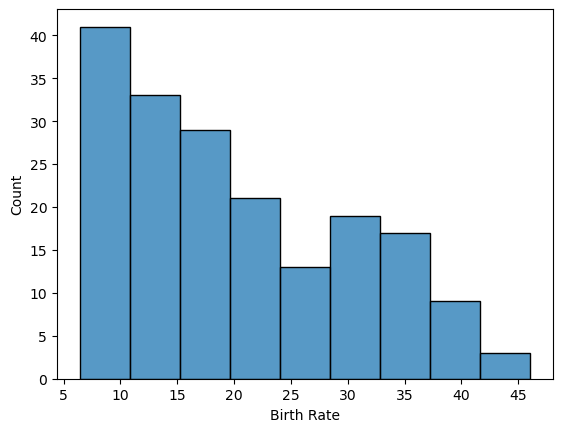

In [351]:
#A look at the histogram for Birth Rate, the dependent variable we will be looking at. We can see shape (right skewed), and there does not appear to be any outliers.
#Most of the birth rates seem to be on the lower side, mostly betweeen the 6-25 range.

sns.histplot(data=df, x="Birth Rate")

In [352]:
#We will create a correlation matrix to see how attributes correlate to each other. It will show, in a visual way, how columns relate. 

# Select only float columns
float_columns = df.select_dtypes(include=['float64'])

# Create a correlation matrix for the float columns
correlation_matrix = float_columns.corr()

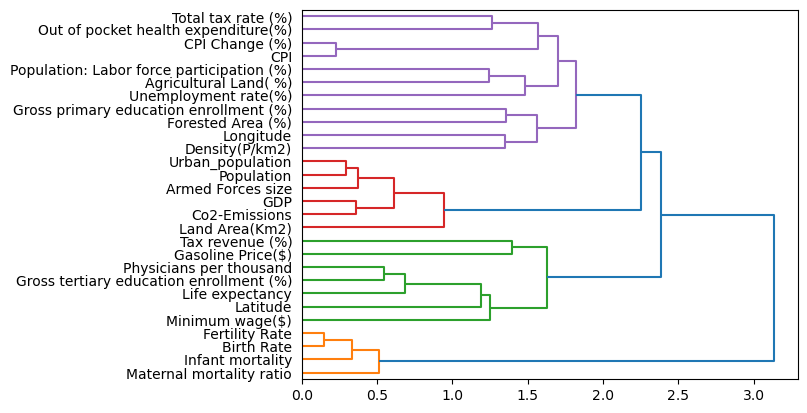

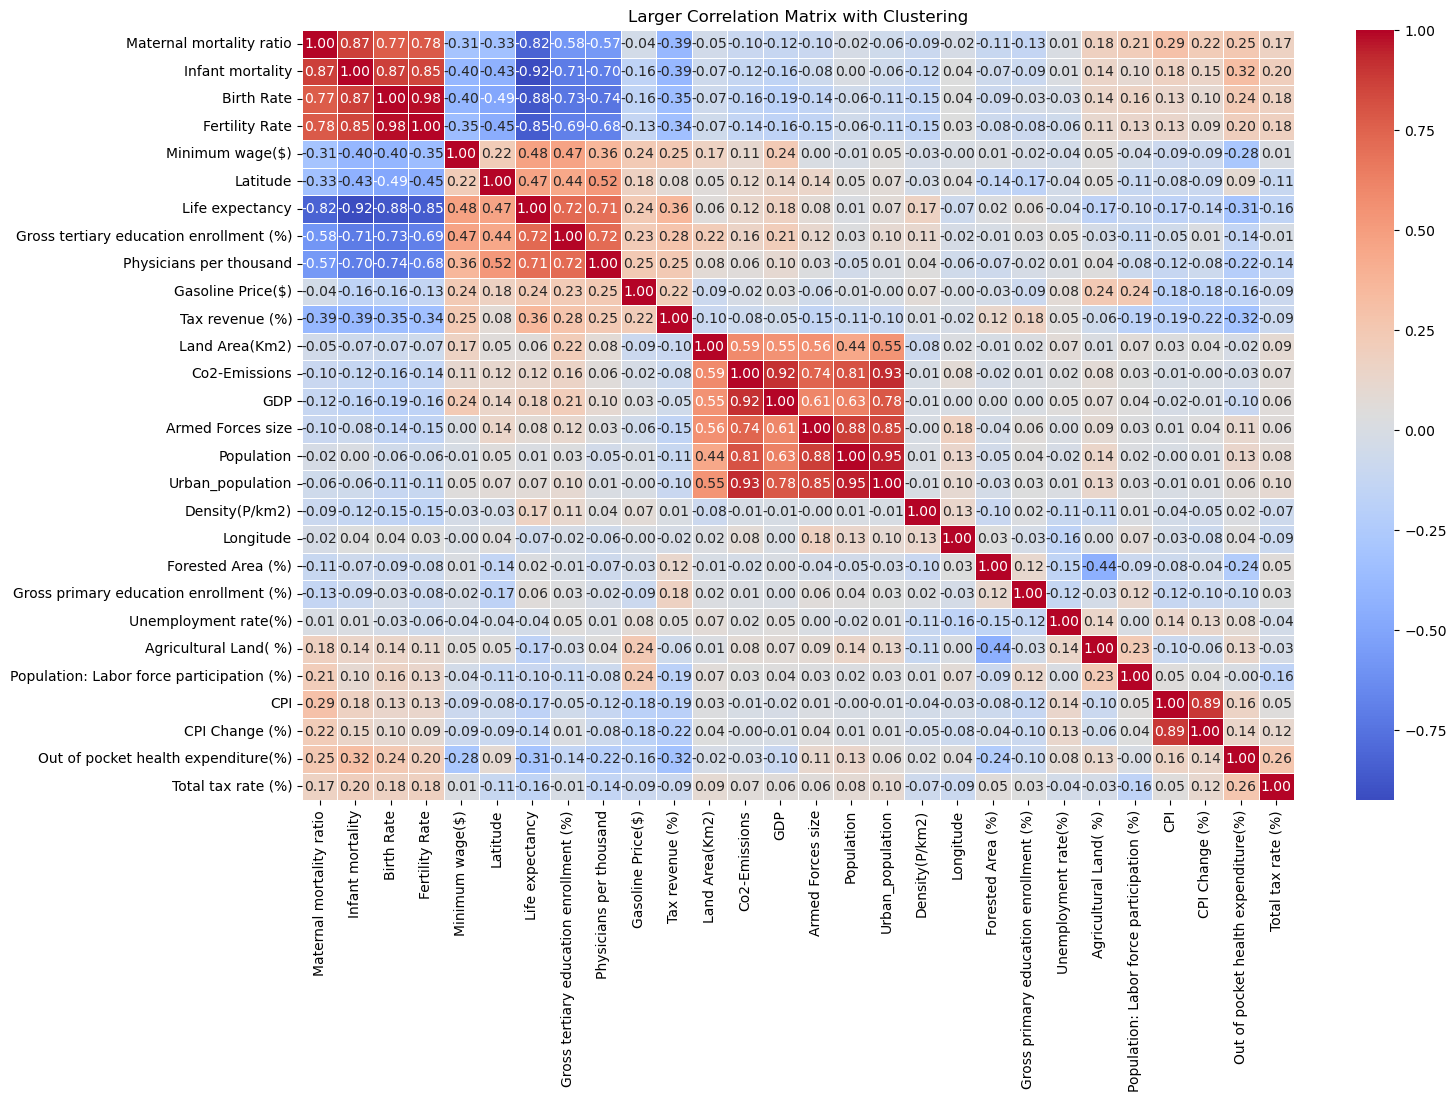

In [353]:
# We perform hierarchical clustering on the corr matrix to create a dendogram which visualizes the columns that are most alike. 
# In future assignments, we should pay attention to multi-collineearity when constructing models. Feertility Rate and Birth Rate seem to be highly correlated, which is logical.
# Fertility Rate might be a candidate to drop as it is highly correlated with the dependent in this case. 
# Life expectancy and the number of physicians seem to be highly negatively correlated, with some moderate negative correlations as well. 

linkage = hierarchy.linkage(correlation_matrix, method='average')
dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, orientation='right')

# Reorder the columns based on clustering
ordered_columns = [correlation_matrix.columns[i] for i in dendrogram['leaves']]
ordered_corr_matrix = correlation_matrix.reindex(ordered_columns)[ordered_columns]

# Create a heatmap with reordered columns
plt.figure(figsize=(16, 10))  # Specify the figsize parameter to make the heatmap larger
sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title('Larger Correlation Matrix with Clustering')

plt.show()

### Scatterplot by birth rate and unemployment rate(%)

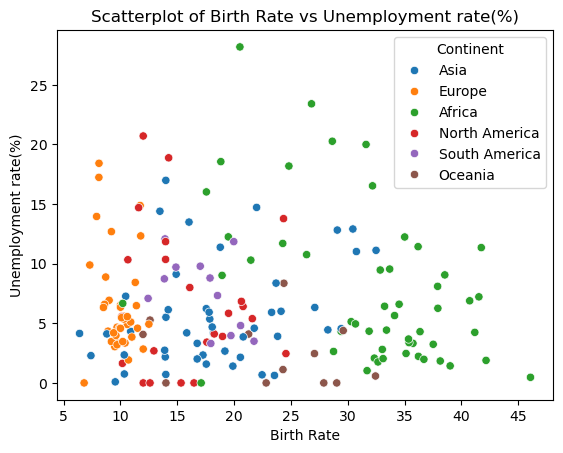

In [354]:
# Using the continent information that we brought in from earlier, we can see that there are fairly clear clusters of Birth Rate by Continent.
# However, UE Rate does not seem to have a clear indicator on Birth Rate, telling us the job market may not have a huge influence. 

sns.scatterplot(data=df, x='Birth Rate', y='Unemployment rate(%)',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('Unemployment rate(%)')
plt.title('Scatterplot of Birth Rate vs Unemployment rate(%)')


plt.show()

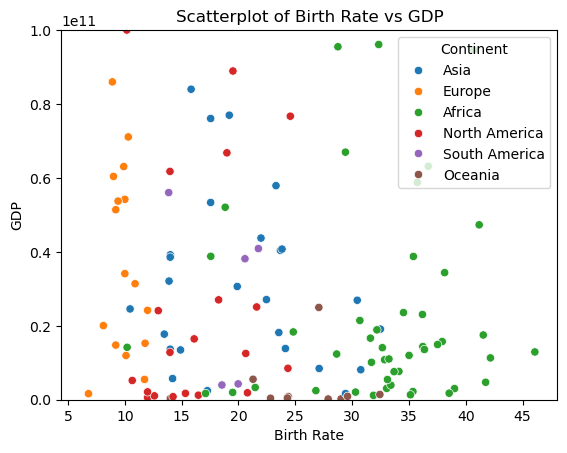

In [355]:
# We create a scatterplot and lower the y-limit to $100B so we can clearly see more datapoints. Seems to be no real correlation here either. 
# Economic factors so far have shown not much indication on Birth Rate.

sns.scatterplot(data=df, x='Birth Rate', y='GDP',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('GDP')
plt.title('Scatterplot of Birth Rate vs GDP')
plt.ylim(0, 100000000000)

plt.show()

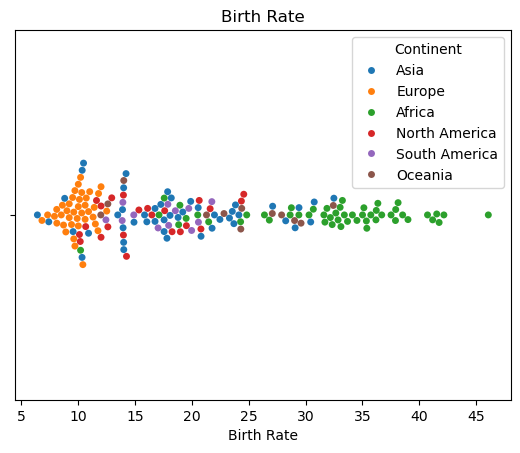

In [356]:
# We have seen above that Birth Rate and Continent have some sort of relationship. 
# The swarm plot shows each data point and upholds our thinking. Especially in the continents of Africa and Europe.


sns.swarmplot(data=df, x="Birth Rate",hue='Continent')

plt.title('Birth Rate')


plt.show()

<Axes: xlabel='Unemployment rate(%)'>

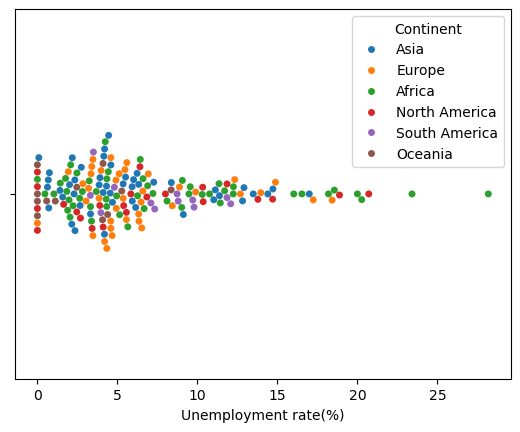

In [357]:
sns.swarmplot(data=df, x="Unemployment rate(%)",hue='Continent')

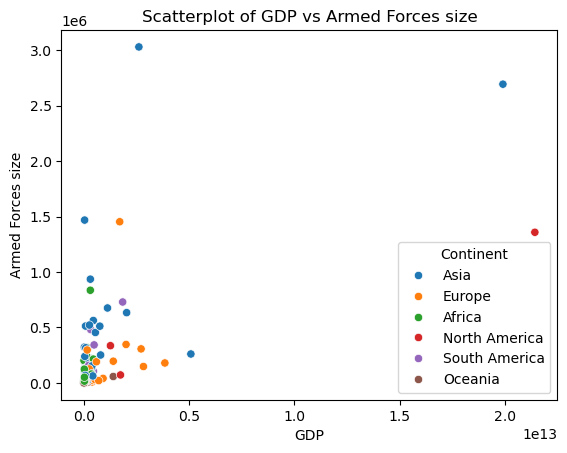

In [358]:
# Create a scatterplot
sns.scatterplot(data=df, x='GDP', y='Armed Forces size',hue='Continent')


plt.xlabel('GDP')
plt.ylabel('Armed Forces size')
plt.title('Scatterplot of GDP vs Armed Forces size')


plt.show()

# Create a map

In [359]:
# Here we have created a map to show the Birth Rates, colored in by certain thresholds. It gives a global view on the values. 
# The Southern Hemisphere seems to have the higher birth rates than the North. While the Eastern Hemisphere has higher values than the West.

m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate over rows in the DataFrame and add markers
for _, row in df.iterrows():
    country_name = row['Country']
    birth_rate = row['Birth Rate']
    latitude = row['Latitude']
    longitude = row['Longitude']

    # Customize marker color based on Birth Rate
    if birth_rate < 10:
        marker_color = 'green'
    elif 10 <= birth_rate < 15:
        marker_color = 'orange'
    else:
        marker_color = 'red'

    # Create markers for each country
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=6,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        popup=f"{country_name}<br>Birth Rate: {birth_rate}",
    ).add_to(m)


In [360]:
m

## Visualizations by languages and continents

In [361]:
most_spoken_languages = df['Official language'].value_counts()
top_10_languages = most_spoken_languages.head(10)
top_10_languages.reset_index()

,Official language,count
0,English,31
1,French,24
2,Spanish,20
3,Arabic,17
4,Portuguese,7
5,Swahili,4
6,Russian,4
7,German,3
8,Italian,2
9,Persian,2


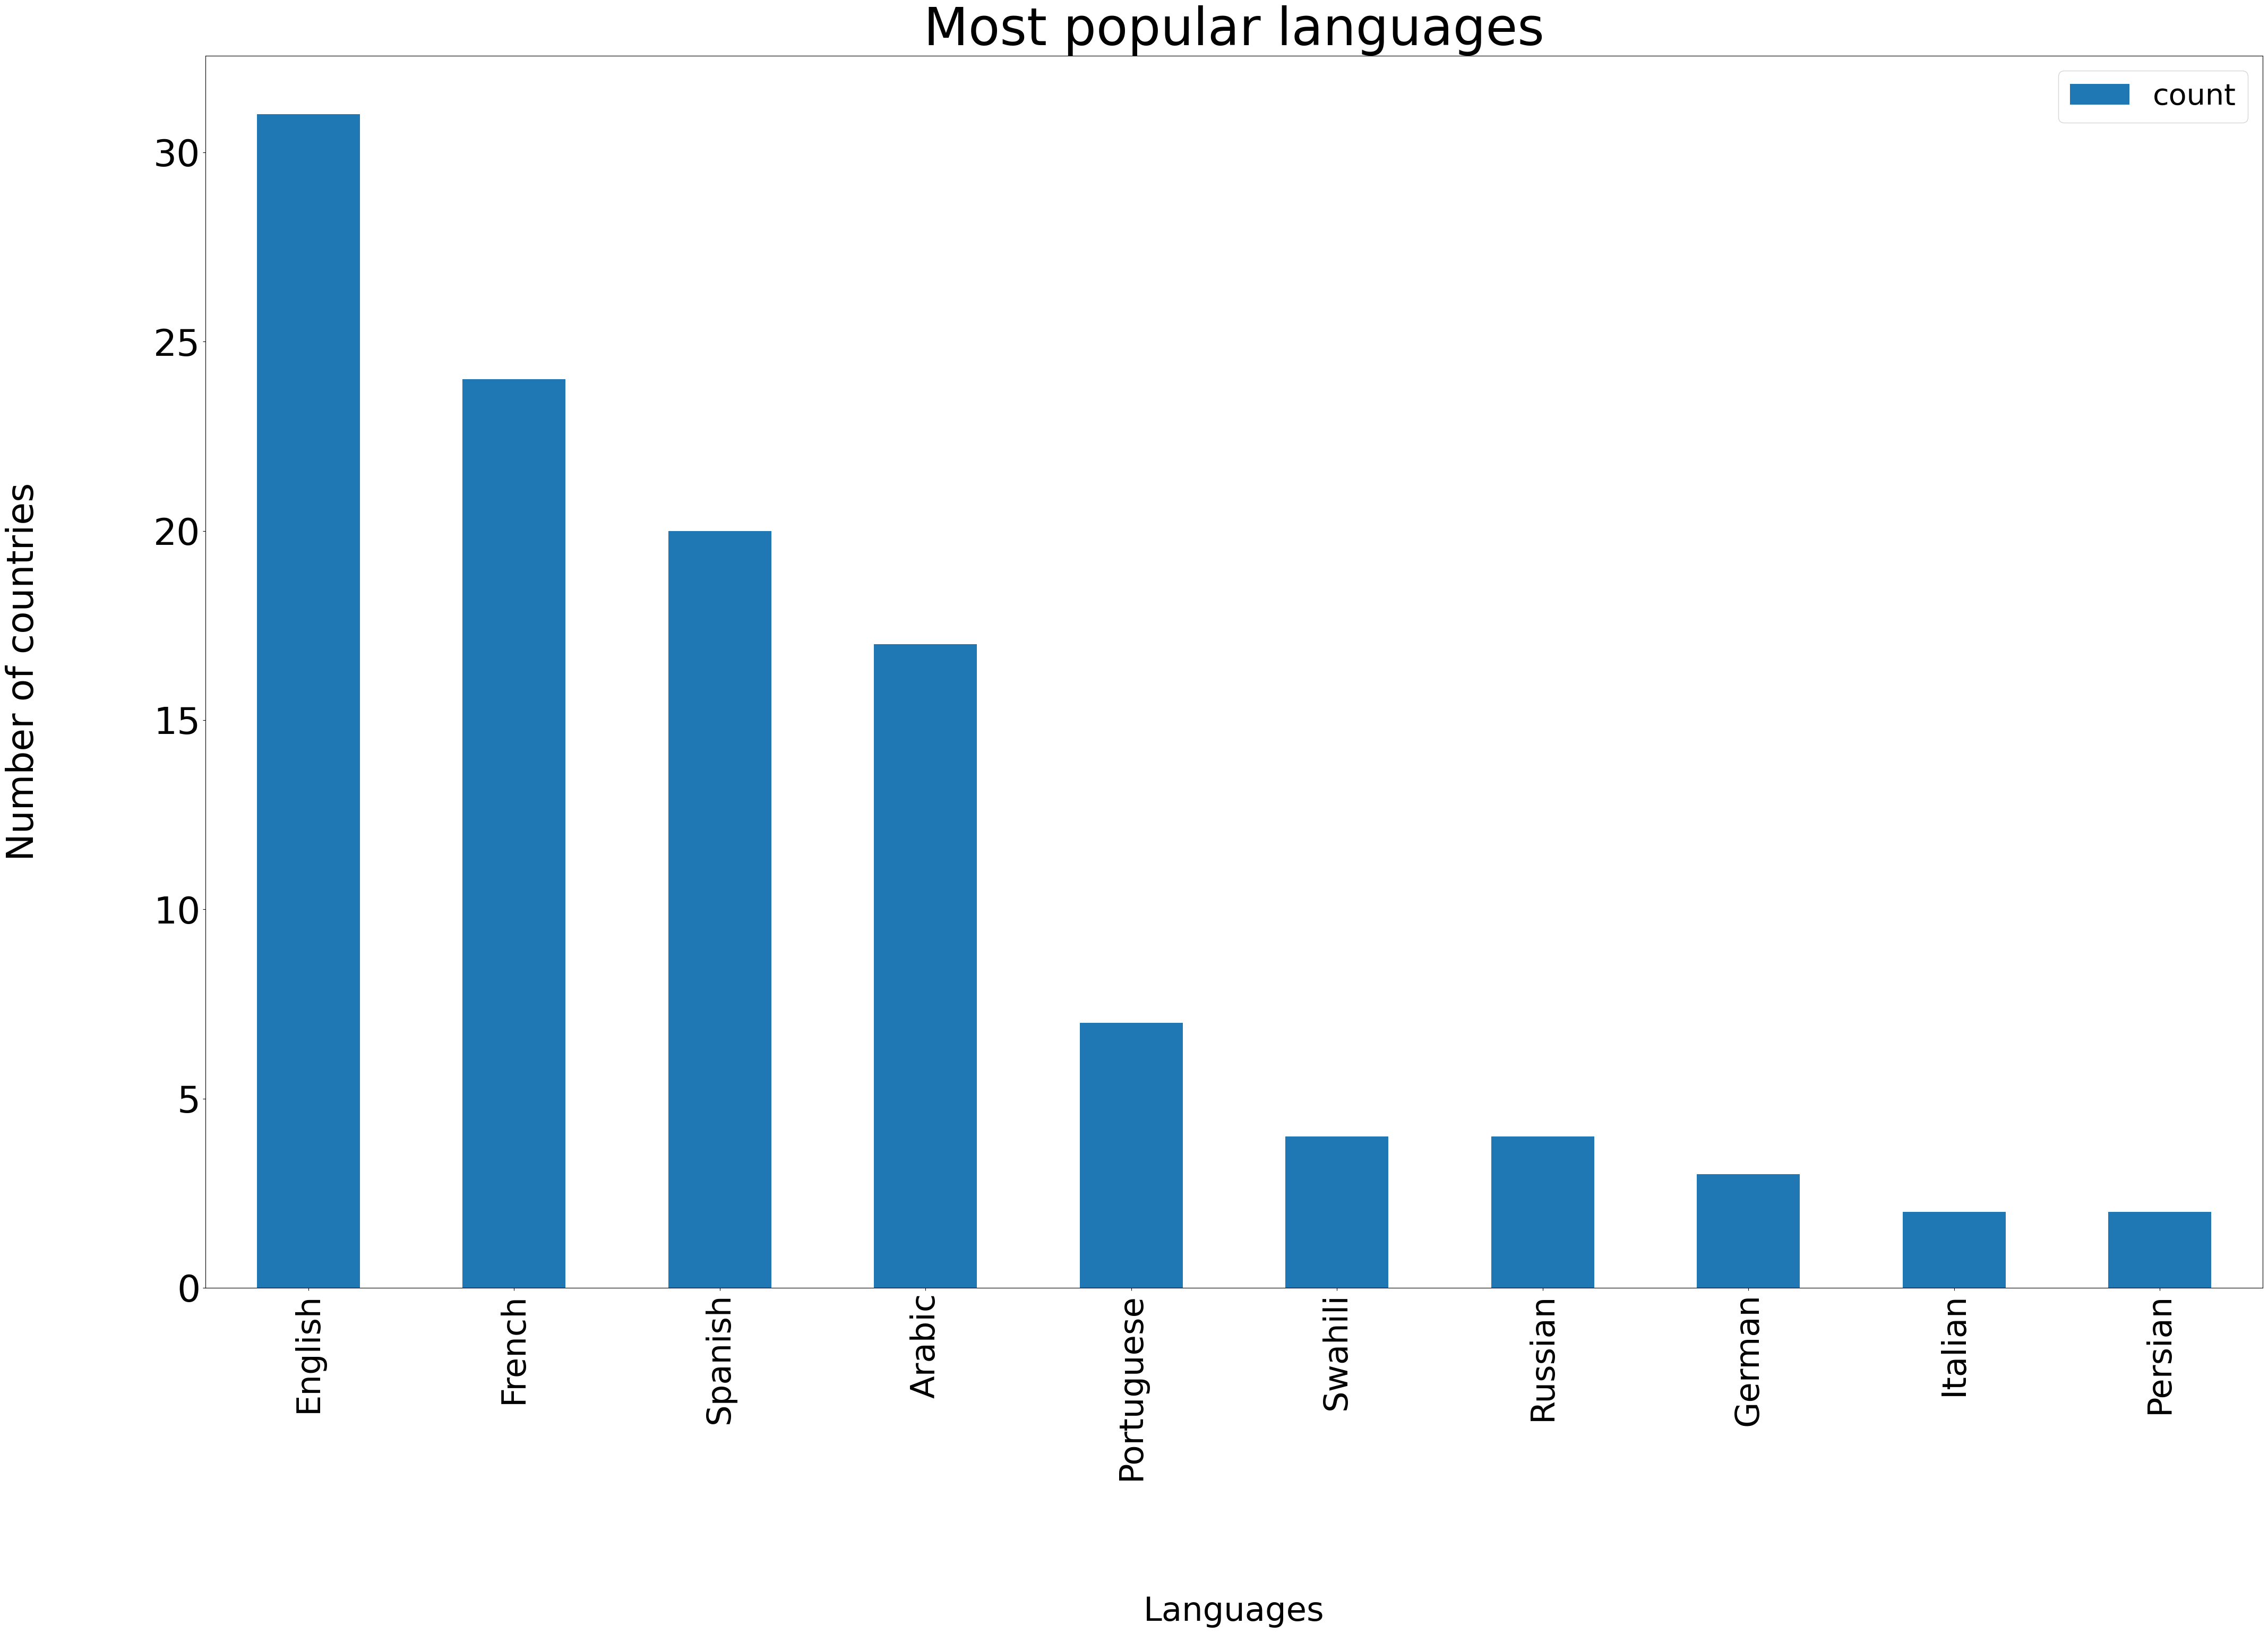

In [362]:
fig,ax = plt.subplots(figsize=(50,40))
top_10_languages.plot(kind='bar',ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Number of countries',fontsize=50)
plt.xlabel('Languages',fontsize=45)

ax.yaxis.set_label_coords(-0.08,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Most popular languages", fontsize=70)



plt.show()

In [363]:
def get_top3(df, language):
    def top(df):
        return df.sort_values(by='Population', ascending=False)[:10]
    
    return df[df['Official language'] == language].groupby('Official language').apply(top).reset_index(drop=True)


top_english_countries = get_top3(df, 'English')
# top_spanish_countries = get_top3(your_dataframe, 'Spanish')
# top_french_countries = get_top3(your_dataframe, 'French')

In [364]:
vis = top_english_countries.pivot_table('Population',index='Country',columns='Continent',aggfunc=sum).T
vis.fillna(0,inplace=True)


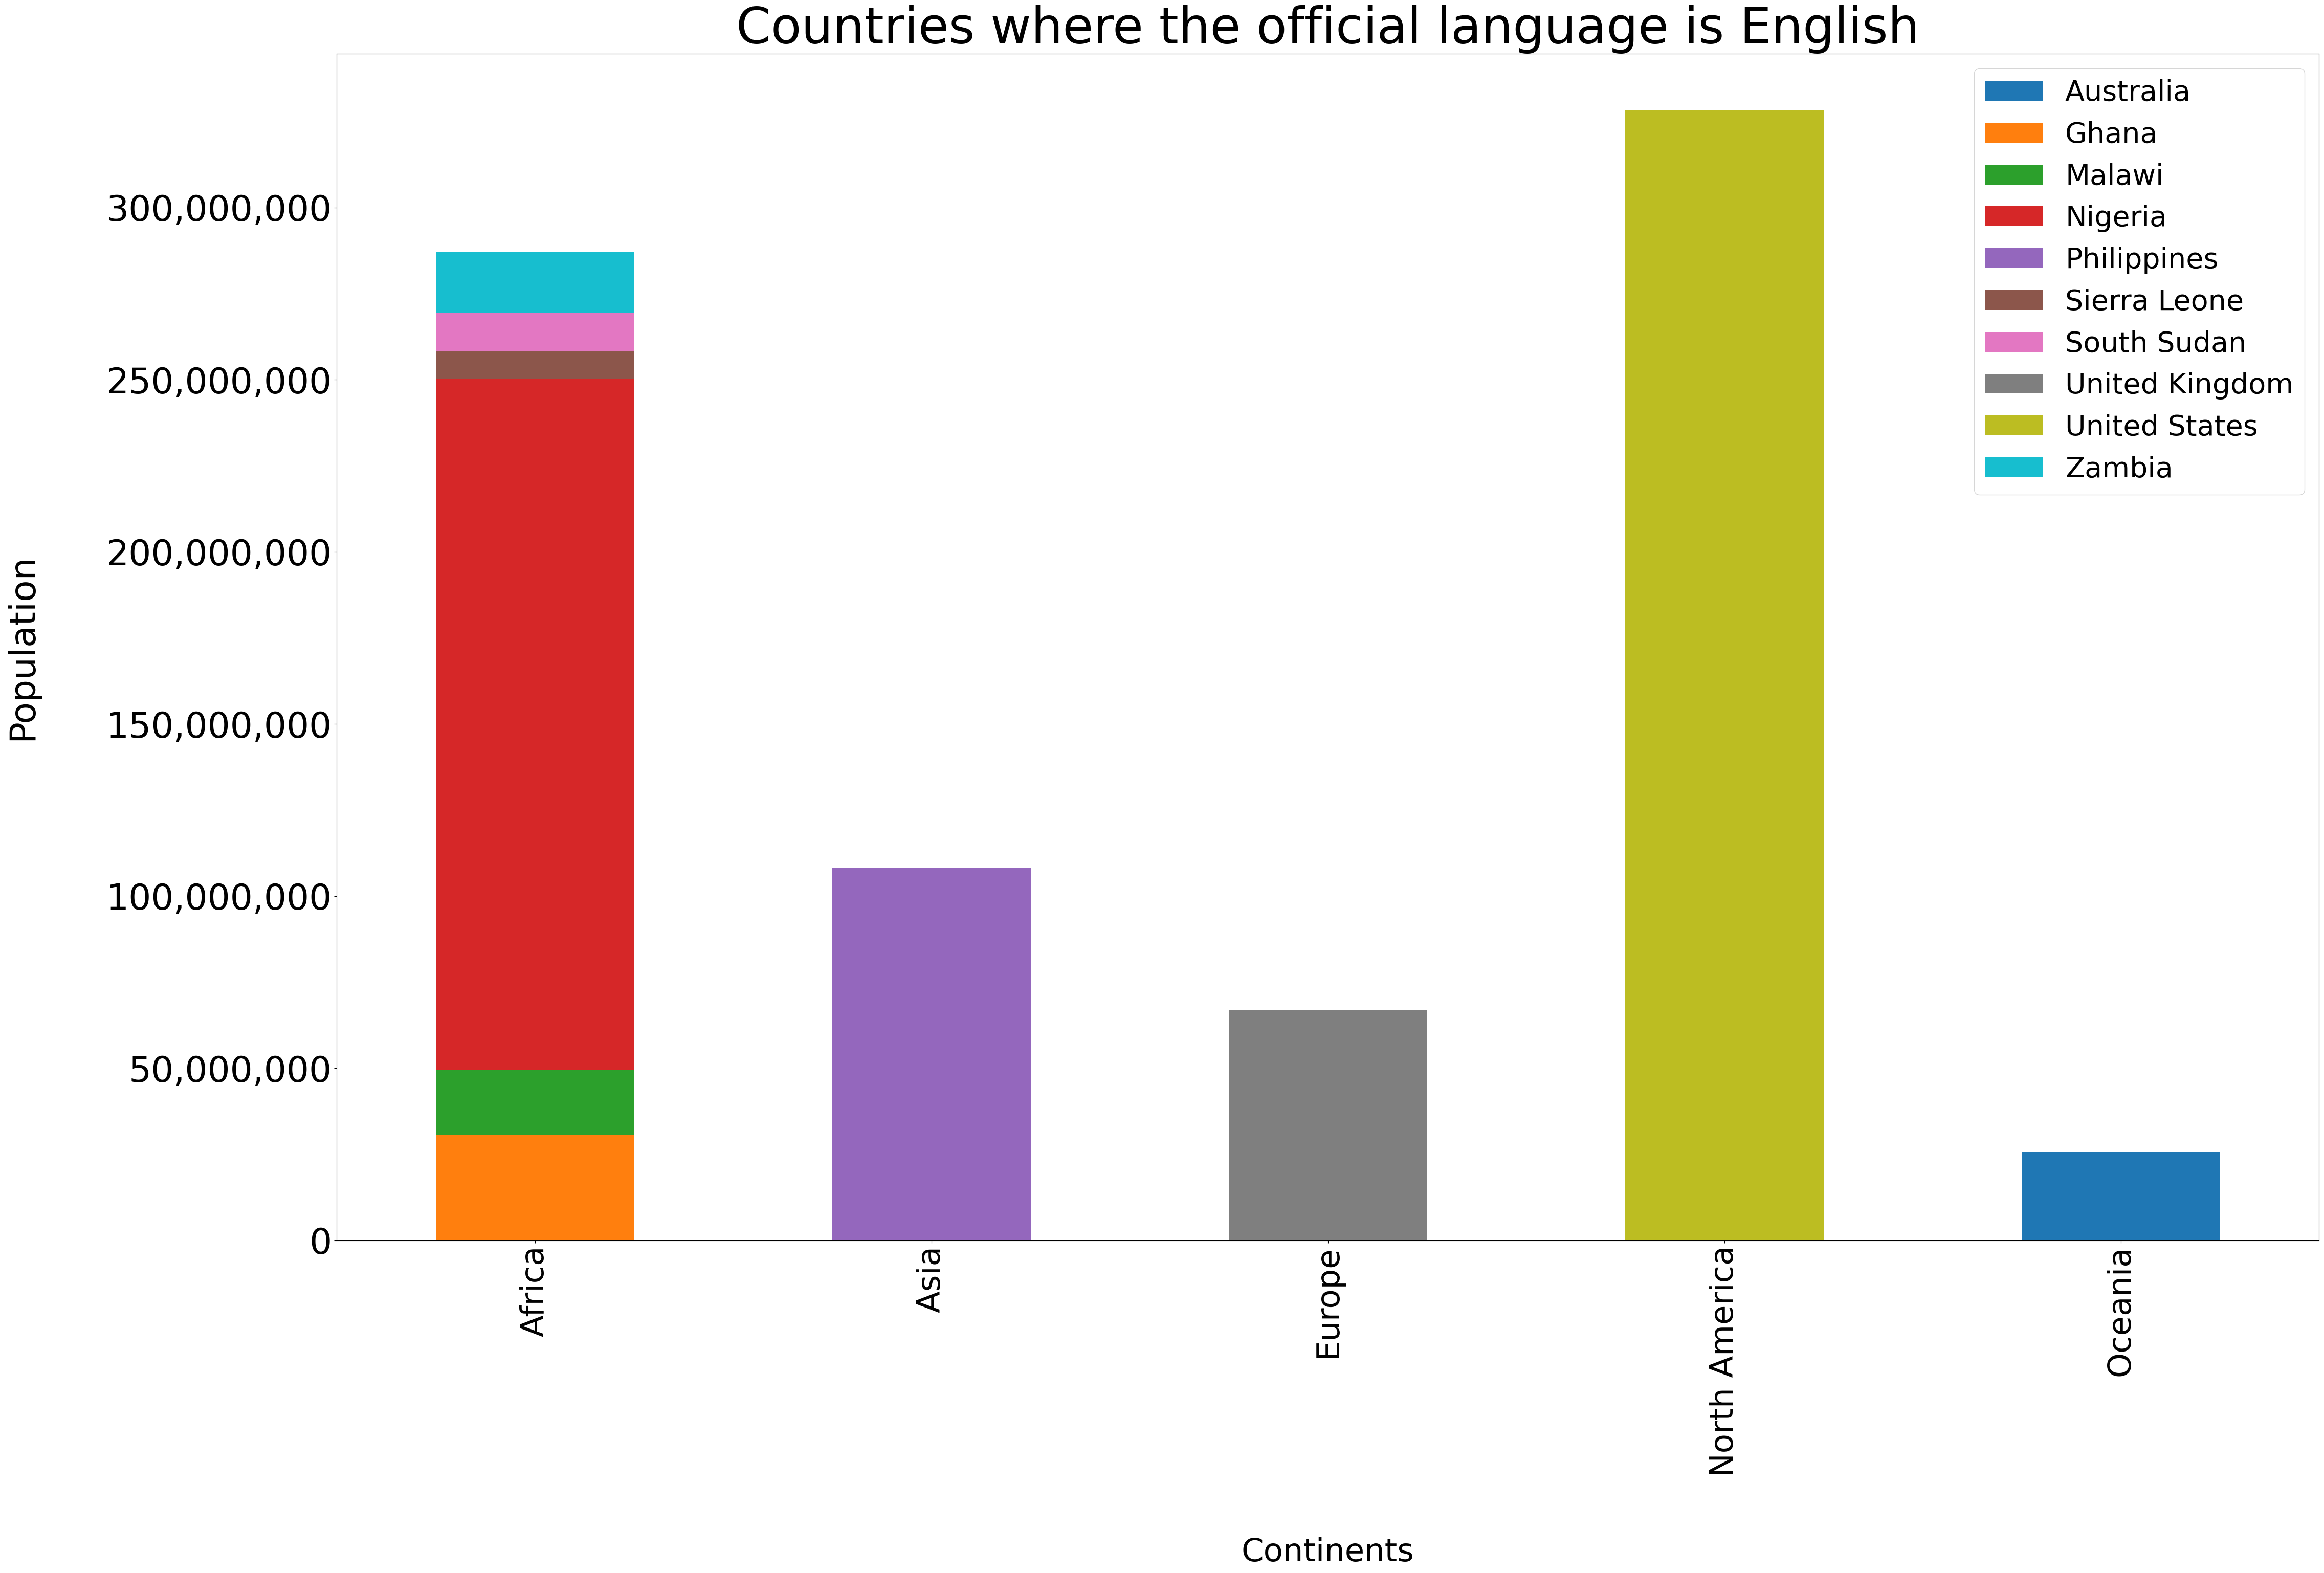

In [365]:
fig,ax = plt.subplots(figsize=(50,40))
vis.plot(kind='bar',stacked=True,ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Population',fontsize=50)
plt.xlabel('Continents',fontsize=45)

ax.yaxis.set_label_coords(-0.15,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Countries where the official language is English", fontsize=70)



plt.show()

In [366]:

scaler = RobustScaler()
numeric_col = df.select_dtypes(include=['number'])

In [367]:
# As we alluded to before, the ranges of the columns are all over the place. We create an instance of MinMaxScaler to bring in the ranges in between 0 and 1.
# This will help us in our modelling as something like Armed Forces size, which has values in the millions sometimes, will not have a skewed weight compared to something like Agricultural Land percentage. 
# We have done this after the visualizations, as the raw numbers there were more useful than what the scaled numbers would be. 

scaler = MinMaxScaler()

numeric_col = df.select_dtypes(include=['number'])



In [368]:
df['Density(P/km2)'] = df['Density(P/km2)'].astype(float)

In [369]:
# Convert 'Column1' to float, skipping the first row
df['Density(P/km2)'] = pd.to_numeric(df['Density(P/km2)'], errors='coerce')

In [370]:
df['Density(P/km2)'].unique()

array([6.000e+01, 1.050e+02, 1.800e+01, 2.600e+01, 2.230e+02, 1.700e+01,
       1.040e+02, 3.000e+00, 1.090e+02, 1.230e+02, 3.900e+01, 2.239e+03,
       1.265e+03, 6.680e+02, 4.700e+01, 3.830e+02, 1.080e+02, 2.000e+01,
       1.100e+01, 6.400e+01, 4.000e+00, 2.500e+01, 8.300e+01, 7.600e+01,
       4.630e+02, 1.380e+02, 9.500e+01, 5.600e+01, 8.000e+00, 1.300e+01,
       1.530e+02, 4.600e+01, 4.670e+02, 1.600e+01, 1.000e+02, 7.300e+01,
       1.060e+02, 1.310e+02, 1.390e+02, 4.000e+01, 1.370e+02, 4.300e+01,
       9.600e+01, 2.250e+02, 7.100e+01, 1.030e+02, 3.130e+02, 5.000e+01,
       3.500e+01, 3.100e+01, 1.150e+02, 4.900e+01, 1.190e+02, 9.000e+00,
       2.390e+02, 5.700e+01, 2.400e+02, 8.100e+01, 3.310e+02, 1.670e+02,
       5.300e+01, 7.000e+01, 4.140e+02, 8.900e+01, 1.070e+02, 4.640e+02,
       1.510e+02, 5.200e+01, 9.300e+01, 7.200e+01, 4.000e+02, 2.060e+02,
       2.730e+02, 3.470e+02, 7.000e+00, 9.400e+01, 1.470e+02, 3.400e+01,
       3.200e+01, 3.000e+01, 6.670e+02, 2.420e+02, 

In [371]:
scaled_data = scaler.fit_transform(numeric_col)

# Replace the original numeric columns in the dataframe with the scaled data

df[numeric_col.columns] = scaled_data

In [372]:
df

,Country,Density(P/km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Urban_population,Latitude,Longitude,Continent,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,Afghanistan,0.006941,0.703390,0.038143,0.106565,0.657510,Kabul,0.000877,0.032703,0.025463,...,0.011606,0.706944,0.687612,Asia,False,True,False,False,False,False
1,Albania,0.012326,0.521792,0.001678,0.002969,0.135585,Tirana,0.000459,0.025972,0.021991,...,0.002056,0.775091,0.553034,Europe,False,False,True,False,False,False
2,Algeria,0.001915,0.210654,0.139294,0.104586,0.450605,Algiers,0.015163,0.033021,0.024306,...,0.037365,0.651163,0.500640,Africa,True,False,False,False,False,False
3,Angola,0.002872,0.575061,0.072911,0.038601,0.865171,Luanda,0.003507,0.057100,0.082562,...,0.024969,0.280529,0.546539,Africa,True,False,False,False,False,False
4,Antigua and Barbuda,0.026448,0.248184,0.000022,0.000000,0.225050,St. John's Saint John,0.000056,0.024829,0.021219,...,0.000011,0.547510,0.321012,North America,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Venezuela,0.003590,0.296610,0.053338,0.113164,0.289315,Caracas,0.016595,0.597828,1.000000,...,0.029834,0.447031,0.307444,South America,False,False,False,False,False,True
181,Vietnam,0.037338,0.475787,0.019368,0.172220,0.260837,Hanoi,0.019475,0.035674,0.027392,...,0.041899,0.519148,0.802448,Asia,False,True,False,False,False,False
182,Yemen,0.006462,0.539952,0.030875,0.013197,0.606099,Sanaa,0.001072,0.034378,0.047840,...,0.012878,0.533264,0.633280,Asia,False,True,False,False,False,False
183,Zambia,0.002753,0.388620,0.044014,0.005279,0.750756,Lusaka,0.000520,0.046318,0.052083,...,0.009321,0.262287,0.574777,Africa,True,False,False,False,False,False


In [373]:
# This is the latest file as of 10/19/2023

In [374]:
#CHANGE MADE BY TOYOSI


In [375]:
# Get a list of column names
column_names = df.columns.tolist()

# Print the list of column names
print(column_names)

['Country', 'Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Capital/Major City', 'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Currency-Code', 'Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Largest city', 'Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)', 'Official language', 'Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population', 'Latitude', 'Longitude', 'Continent', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America']


In [376]:
#'Birth Rate'
selected_features = df[['Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size',   'Co2-Emissions', 'CPI', 'CPI Change (%)',  'Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)',  'Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population',   'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 
                        'Continent_South America']]

# Descriptive Data Mining
## Clustering Analysis

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to ha

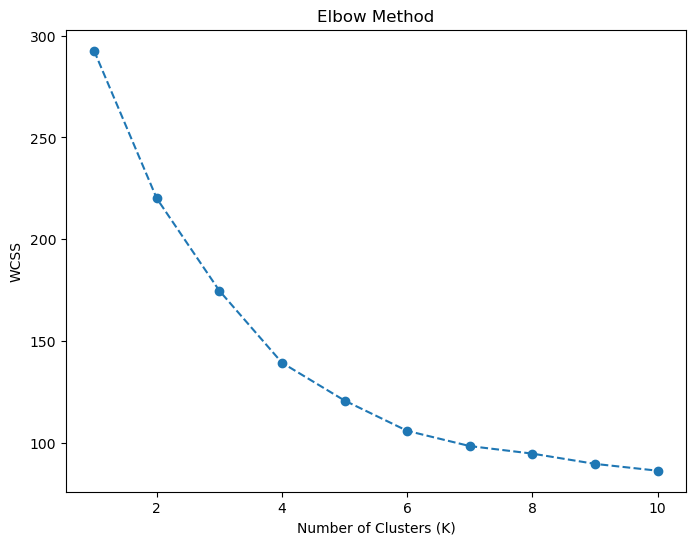

<Figure size 640x480 with 0 Axes>

In [377]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(selected_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()
plt.savefig('Elbow_method.png')

In [378]:
k = 3  # Replace with your chosen K value
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
kmeans.fit(selected_features)

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [379]:
cluster_labels = kmeans.labels_

In [380]:
df['Cluster_Labels'] = cluster_labels

In [381]:
cluster_df = df[['Country','Cluster_Labels']]
cluster_df = cluster_df.sort_values(by='Cluster_Labels', ascending=False)
cluster_df

,Country,Cluster_Labels
92,Lesotho,2
68,Guinea-Bissau,2
104,Mauritania,2
101,Mali,2
98,Malawi,2
...,...,...
122,Norway,0
71,Honduras,0
15,Belgium,0
16,Belize,0


In [382]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to ha

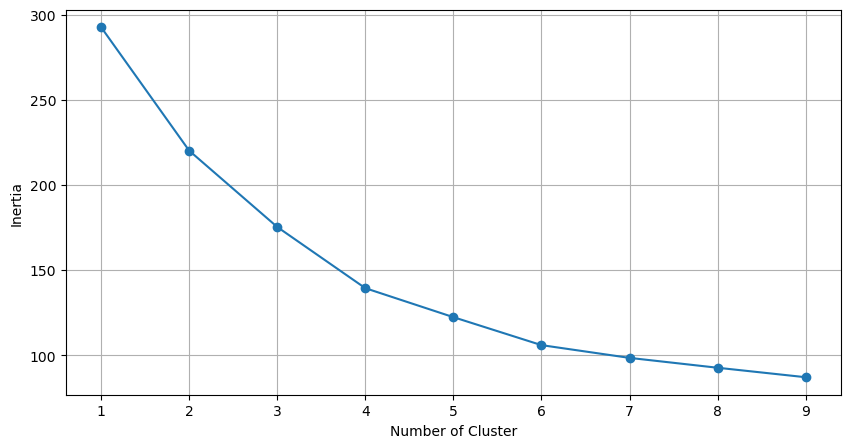

In [383]:
optimize_k_means(selected_features,10)

In [384]:
for k in range(2, 10):  # Try different values of K
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(selected_features)
    silhouette_avg = silhouette_score(selected_features, cluster_labels)
    print(f"For K = {k}, the average silhouette score is: {silhouette_avg}")

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to ha

For K = 2, the average silhouette score is: 0.25681747399438287
For K = 3, the average silhouette score is: 0.30219868958903245
For K = 4, the average silhouette score is: 0.37129786824111644
For K = 5, the average silhouette score is: 0.4072999436145591
For K = 6, the average silhouette score is: 0.43482562481172815
For K = 7, the average silhouette score is: 0.38690218580178054
For K = 8, the average silhouette score is: 0.3316888162400924
For K = 9, the average silhouette score is: 0.3074290540515809


C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [385]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(selected_features)

In [386]:
for k in range(2, 10):  # Try different values of K
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    print(f"For K = {k}, the average silhouette score is: {silhouette_avg}")

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to ha

For K = 2, the average silhouette score is: 0.5425032884650949
For K = 3, the average silhouette score is: 0.6622188851572115
For K = 4, the average silhouette score is: 0.7022572317816105
For K = 5, the average silhouette score is: 0.6623048185123911
For K = 6, the average silhouette score is: 0.6153584634979327
For K = 7, the average silhouette score is: 0.5670234912176149
For K = 8, the average silhouette score is: 0.5331217988878352
For K = 9, the average silhouette score is: 0.4872961894505675


C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [387]:
## Change Made by ang

### Clustering Graphs 1  (Infant mortality VS Fertility Rate)

In [395]:
df_Fertility_Infant_Mortality=df[['Fertility Rate','Infant mortality']]
df_Fertility_Infant_Mortality

,Fertility Rate,Infant mortality
0,0.588533,0.559567
1,0.107926,0.077016
2,0.344013,0.225030
3,0.765599,0.604091
4,0.170320,0.043321
...,...,...
180,0.217538,0.240674
181,0.180438,0.181709
182,0.473862,0.499398
183,0.615514,0.469314


In [396]:
k=3

In [397]:
kmeans_1=KMeans(n_clusters=k)

In [398]:
kmeans_1.fit(df_Fertility_Infant_Mortality)

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

In [399]:
df_Fertility_Infant_Mortality['Cluster']=kmeans_1.labels_

C:\Users\angdo\AppData\Local\Temp\ipykernel_20296\46822261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Fertility_Infant_Mortality['Cluster']=kmeans_1.labels_


In [400]:
centroids_1= kmeans_1.cluster_centers_

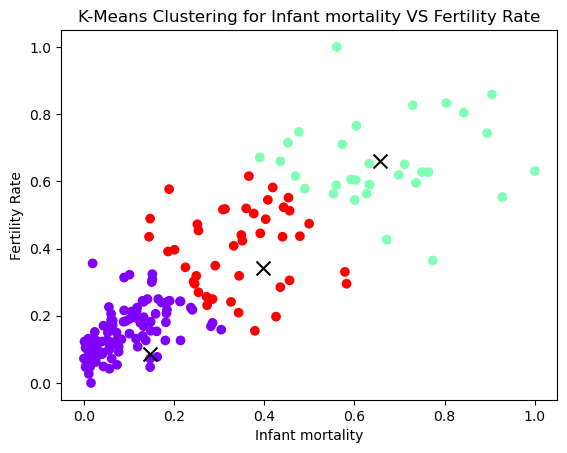

In [401]:
plt.scatter(df_Fertility_Infant_Mortality['Infant mortality'],df_Fertility_Infant_Mortality['Fertility Rate'], c=df_Fertility_Infant_Mortality['Cluster'], cmap='rainbow')
plt.scatter(centroids_1[:, 0], centroids_1[:, 1], c='black', marker='x', s=100, label='Centroids_1')
plt.xlabel('Infant mortality')
plt.ylabel('Fertility Rate')
plt.title('K-Means Clustering for Infant mortality VS Fertility Rate')
plt.show()

### Clustering Graphs 2 ( Maternal Motality Rate and physican per thousand)

In [402]:
df_Maternalmortality_Physiciansperthousand=df[['Maternal mortality ratio','Physicians per thousand']]

In [403]:
is_null = df['Physicians per thousand'].isnull() # checking the null data
num_null_values = is_null.sum()
print(f"Number of null values in 'Physicians per thousand': {num_null_values}")

Number of null values in 'Physicians per thousand': 0


In [404]:
k=3

In [405]:
kmeans_2=KMeans(n_clusters=k)

In [406]:
kmeans_2.fit(df_Maternalmortality_Physiciansperthousand)

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

In [407]:
df_Maternalmortality_Physiciansperthousand['Cluster']=kmeans_2.labels_

C:\Users\angdo\AppData\Local\Temp\ipykernel_20296\3440604516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Maternalmortality_Physiciansperthousand['Cluster']=kmeans_2.labels_


In [408]:
centroids_2=kmeans_2.cluster_centers_

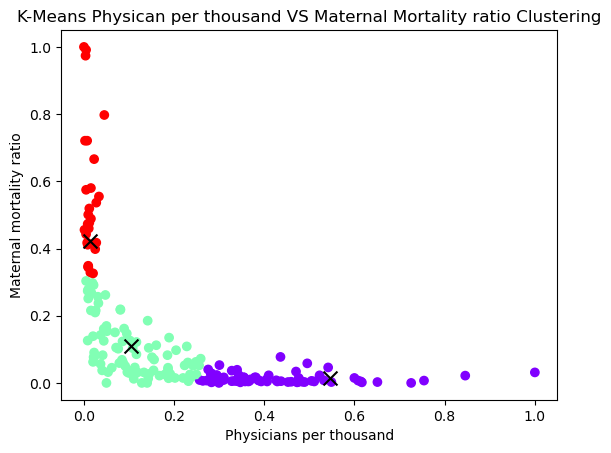

In [409]:
plt.scatter(df_Maternalmortality_Physiciansperthousand['Physicians per thousand'],df_Maternalmortality_Physiciansperthousand['Maternal mortality ratio'], c=df_Maternalmortality_Physiciansperthousand['Cluster'], cmap='rainbow')
plt.scatter(centroids_2[:, 0], centroids_2[:, 1], c='black', marker='x', s=100, label='Centroids_2')
plt.xlabel('Physicians per thousand')
plt.ylabel('Maternal mortality ratio')
plt.title('K-Means Physican per thousand VS Maternal Mortality ratio Clustering')
plt.show()

### Clustering Graphs 3:  Birth rate and Infant Mortality rate 

In [410]:
df_Birth_Infantmortality=df[['Birth Rate','Infant mortality']]

In [411]:
k=3
kmeans_3=KMeans(n_clusters=k)

In [412]:
kmeans_3.fit(df_Birth_Infantmortality)

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

In [413]:
df_Birth_Infantmortality['Cluster']=kmeans_3.labels_

C:\Users\angdo\AppData\Local\Temp\ipykernel_20296\2061575391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Birth_Infantmortality['Cluster']=kmeans_3.labels_


In [414]:
centroids_3= kmeans_3.cluster_centers_

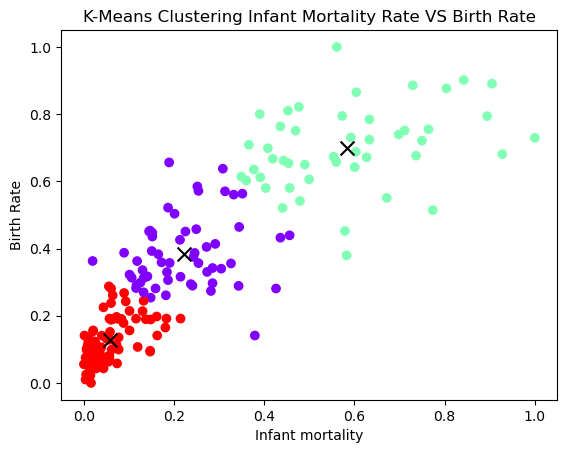

In [415]:
plt.scatter(df_Birth_Infantmortality['Infant mortality'], df_Birth_Infantmortality['Birth Rate'], c=df_Birth_Infantmortality['Cluster'], cmap='rainbow')
plt.scatter( centroids_3[:, 1],centroids_3[:, 0], c='black', marker='x', s=100, label='Centroids_3')
plt.xlabel('Infant mortality')
plt.ylabel('Birth Rate')
plt.title('K-Means Clustering Infant Mortality Rate VS Birth Rate')
plt.show()

### Clustering Graphs 4:   Life Expectency and Physicans per thousand

In [418]:
df_Lifeexpectancy_Physiciansperthousand=df[['Life expectancy','Physicians per thousand']]

In [419]:
k=3
kmeans_4=KMeans(n_clusters=k)

In [420]:
kmeans_4.fit(df_Lifeexpectancy_Physiciansperthousand)

C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\angdo\anaconda3\envs\project\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

In [421]:
df_Lifeexpectancy_Physiciansperthousand['Cluster']=kmeans_4.labels_

C:\Users\angdo\AppData\Local\Temp\ipykernel_20296\1593513463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Lifeexpectancy_Physiciansperthousand['Cluster']=kmeans_4.labels_


In [422]:
centroids_4= kmeans_4.cluster_centers_

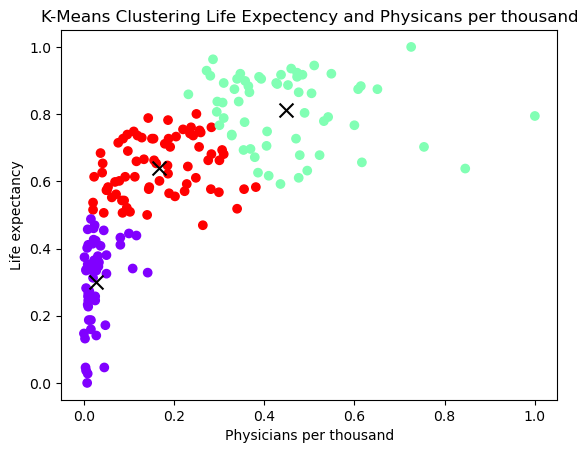

In [423]:
plt.scatter(df_Lifeexpectancy_Physiciansperthousand['Physicians per thousand'], df_Lifeexpectancy_Physiciansperthousand['Life expectancy'], c=df_Lifeexpectancy_Physiciansperthousand['Cluster'], cmap='rainbow')
plt.scatter(centroids_4[:, 1],centroids_4[:, 0], c='black', marker='x', s=100, label='Centroids_4')
plt.xlabel('Physicians per thousand')
plt.ylabel('Life expectancy')
plt.title('K-Means Clustering Life Expectency and Physicans per thousand')
plt.show()

## Association Rule 

In [424]:
print(df_population_data)

                 Country  Population  Maternal mortality ratio  Birth Rate  \
0            Afghanistan  38,041,754                     638.0       32.49   
1                Albania   2,854,191                      15.0       11.78   
2                Algeria  43,053,054                     112.0       24.28   
4                 Angola  31,825,295                     241.0       40.73   
5    Antigua and Barbuda      97,118                      42.0       15.33   
..                   ...         ...                       ...         ...   
190            Venezuela  28,515,829                     125.0       17.88   
191              Vietnam  96,462,106                      43.0       16.75   
192                Yemen  29,161,922                     164.0       30.45   
193               Zambia  17,861,030                     213.0       36.19   
194             Zimbabwe  14,645,468                     458.0       30.68   

     Infant mortality  Physicians per thousand  Fertility Rate 

In [425]:
numerical_attributes= ['Population','Maternal mortality ratio','Birth Rate','Infant mortality','Physicians per thousand','Fertility Rate','GDP','Armed Forces size','Co2-Emissions','Life expectancy']
num_bins=3

In [426]:
bin_labels=['Low','Medium','High']

In [427]:
binned_attributes= {}

In [428]:
for attr in numerical_attributes:
    df_population_data[attr] = pd.to_numeric(df_population_data[attr], errors='coerce')
    df_population_data[attr].fillna(-1, inplace=True)
    df_population_data[attr + 'Bins'] = pd.cut(df_population_data[attr], bins=num_bins, labels=bin_labels)
    binned_attributes[attr] = attr + 'Bins'

In [429]:
print(df_population_data)

                 Country  Population  Maternal mortality ratio  Birth Rate  \
0            Afghanistan        -1.0                     638.0       32.49   
1                Albania        -1.0                      15.0       11.78   
2                Algeria        -1.0                     112.0       24.28   
4                 Angola        -1.0                     241.0       40.73   
5    Antigua and Barbuda        -1.0                      42.0       15.33   
..                   ...         ...                       ...         ...   
190            Venezuela        -1.0                     125.0       17.88   
191              Vietnam        -1.0                      43.0       16.75   
192                Yemen        -1.0                     164.0       30.45   
193               Zambia        -1.0                     213.0       36.19   
194             Zimbabwe        -1.0                     458.0       30.68   

     Infant mortality  Physicians per thousand  Fertility Rate 

In [430]:
df_population_bins=df_population_data[['Country','PopulationBins','Maternal mortality ratioBins','Birth RateBins','Infant mortalityBins','Physicians per thousandBins','Fertility RateBins','GDPBins','Armed Forces sizeBins','Co2-EmissionsBins','Life expectancyBins']]

In [431]:
df_population_bins

,Country,PopulationBins,Maternal mortality ratioBins,Birth RateBins,Infant mortalityBins,Physicians per thousandBins,Fertility RateBins,GDPBins,Armed Forces sizeBins,Co2-EmissionsBins,Life expectancyBins
0,Afghanistan,Medium,Medium,Medium,Medium,Low,Medium,Medium,Low,Low,Medium
1,Albania,Medium,Low,Low,Low,Low,Low,Medium,Low,Low,High
2,Algeria,Medium,Low,Medium,Low,Low,Medium,Medium,Low,Low,High
4,Angola,Medium,Low,High,Medium,Low,High,Medium,Low,Low,Low
5,Antigua and Barbuda,Medium,Low,Low,Low,Medium,Low,Medium,High,High,High
...,...,...,...,...,...,...,...,...,...,...,...
190,Venezuela,Medium,Low,Low,Low,Low,Low,Medium,Low,Low,Medium
191,Vietnam,Medium,Low,Low,Low,Low,Low,Medium,Low,Low,High
192,Yemen,Medium,Low,Medium,Medium,Low,Medium,Medium,Low,Low,Medium
193,Zambia,Medium,Low,High,Medium,Low,Medium,Medium,Low,Low,Low


### The Apriori Algorithm  could not be performed as it is applicable only for binary data